In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [193]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import signal
df = pd.read_csv('/content/drive/My Drive/capstone/LBMA-GOLD.csv',header=0)
df.head()

,Date,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
0,2020-10-02,1906.40,1903.05,1473.46,1471.82,1627.87,1624.44
1,2020-10-01,1895.55,1902.00,1477.01,1476.33,1615.96,1619.74
2,2020-09-30,1883.40,1886.90,1468.49,1467.63,1609.74,1613.30
3,2020-09-29,1882.40,1883.95,1461.87,1465.71,1610.02,1606.44
4,2020-09-28,1850.95,1864.30,1440.78,1448.37,1589.41,1597.52


In [194]:
def nan_checker(df):
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    df_nan = df_nan.sort_values(by='proportion', ascending=False)
    return df_nan
df_nan = nan_checker(df)
df_nan.reset_index(drop=True)

,var,proportion,dtype
0,EURO (PM),0.590776,float64
1,EURO (AM),0.587702,float64
2,GBP (PM),0.011399,float64
3,USD (PM),0.010574,float64
4,GBP (AM),0.000825,float64
5,USD (AM),0.000075,float64


In [195]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.sort_values(by='Date', inplace=True, ascending=True)
df.index = df['Date']
df.drop('Date',axis = 1, inplace = True)
df.columns.values[0] = 'USD'
gold = df.iloc[: , [0]].copy()
gold.head(5)

,USD
Date,
1968-01-02,35.18
1968-01-03,35.16
1968-01-04,35.14
1968-01-05,35.14
1968-01-08,35.14


In [196]:
gold.isnull().sum()
gold.dropna(inplace=True)
df_nan = nan_checker(gold)
df_nan.reset_index(drop=True)

,var,proportion,dtype


In [197]:
def get_auto_corr(timeSeries,k):
    l = len(timeSeries)
    timeSeries1 = timeSeries[0:l-k]
    timeSeries2 = timeSeries[k:]
    timeSeries_mean = np.mean(timeSeries)
    timeSeries_var = np.array([i**2 for i in timeSeries-timeSeries_mean]).sum()
    auto_corr = 0
    for i in range(l-k):
        temp = (timeSeries1[i]-timeSeries_mean)*(timeSeries2[i]-timeSeries_mean)/timeSeries_var
        auto_corr = auto_corr + temp
    return auto_corr

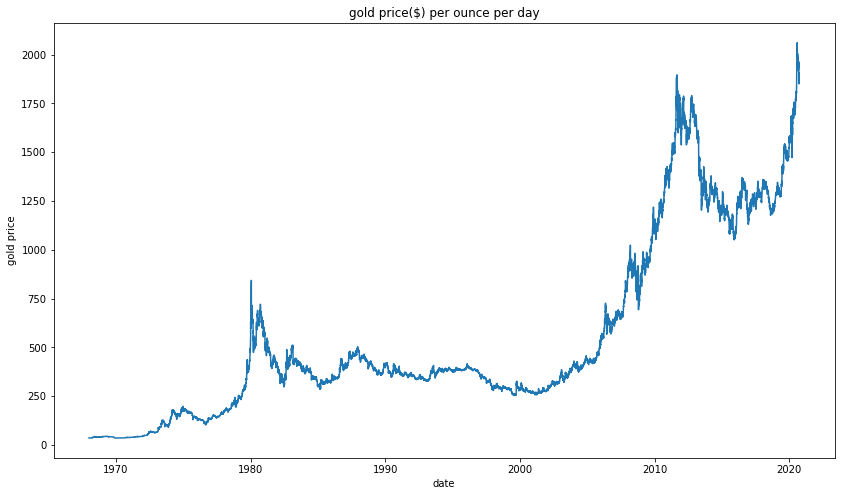

In [198]:
plt.figure(figsize=(14,8))
plt.plot(gold['USD'])
plt.xlabel('date')
plt.ylabel('gold price')
plt.title('gold price($) per ounce per day')
plt.show()

In [199]:
from statsmodels.tsa.stattools import adfuller
stat =gold['USD'].values
result = adfuller(stat)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.097677
p-value: 0.995197
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


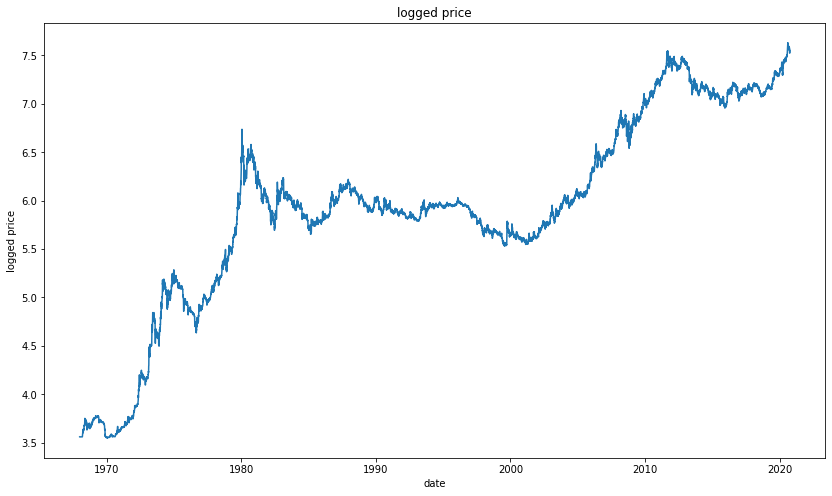

In [200]:
gold['log']=np.log(gold['USD'])
plt.figure(figsize=(14,8))
plt.plot(gold['log'])
plt.xlabel('date')
plt.ylabel('logged price')
plt.title('logged price')
plt.show()

In [201]:
gold['diff']=(gold['log']-gold['log'].shift(1)).dropna()
gold=gold.drop(gold.index[0])
gold.head()

,USD,log,diff
Date,,,
1968-01-03,35.16,3.559909,-0.000569
1968-01-04,35.14,3.559340,-0.000569
1968-01-05,35.14,3.559340,0.000000
1968-01-08,35.14,3.559340,0.000000
1968-01-09,35.14,3.559340,0.000000


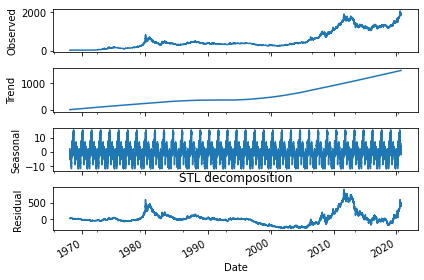

In [400]:
!pip install stldecompose
from stldecompose import decompose
decomp = decompose(gold['USD'], period=365)
decomp.plot()
plt.title('STL decomposition')
plt.show()

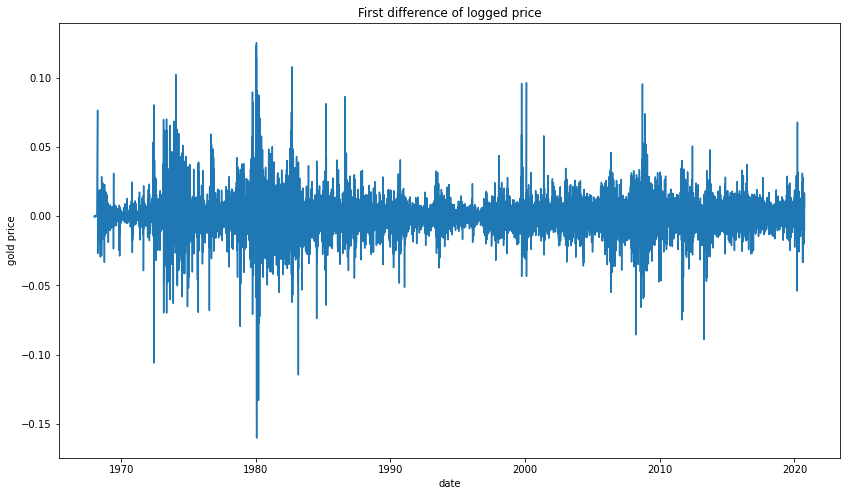

In [202]:
plt.figure(figsize=(14,8))
plt.plot(gold['diff'])
plt.xlabel('date')
plt.ylabel('gold price')
plt.title('First difference of logged price')
plt.show()

In [203]:
from statsmodels.tsa.stattools import adfuller
stat =gold['diff'].values
result = adfuller(stat)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.552357
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


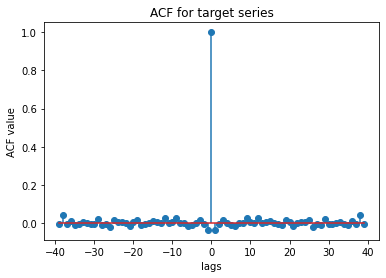

In [204]:
dep=np.array(gold['diff'])
acf=[]
for i in range(40):
    acf.append(get_auto_corr(dep,i))
L1=np.arange(0,40,1)
L2=-L1[::-1]
x = np.concatenate((L2[0:-1], L1))
acf_reverse = acf[::-1]
ACF = np.concatenate ((acf_reverse[0:-1], acf))
plt.stem(x,ACF, use_line_collection=True, markerfmt = 'o')
plt.xlabel('lags')
plt.ylabel('ACF value')
plt.title('ACF for target series')
plt.show()

In [205]:
from sklearn.model_selection import train_test_split
Y=gold[['diff']]
y_train,y_test=train_test_split(Y,test_size=0.3,shuffle=False)
y_test.head()

,diff
Date,
2004-12-06,0.014588
2004-12-07,-0.004398
2004-12-08,-0.017788
2004-12-09,-0.019024
2004-12-10,-0.007920


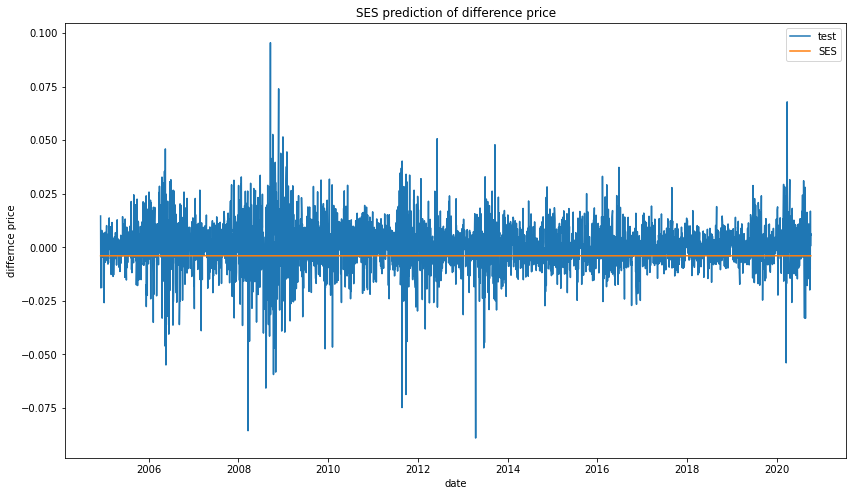

In [211]:
from statsmodels.tsa.api import SimpleExpSmoothing
model_ses = SimpleExpSmoothing(np.asarray(y_train['diff'])).fit(smoothing_level=0.5,optimized=False)
y_test['SES'] = model_ses.forecast(len(y_test))
#raw=np.array(y_test_residual['first'])
#error_ses=raw-y_test_residual['residual'].values
plt.figure(figsize=(14,8))
plt.plot(y_test['diff'],label="test")
plt.plot(y_test['SES'],label="SES")
plt.legend(loc="best")
plt.title('SES prediction of difference price')
plt.xlabel('date')
plt.ylabel('differnce price')
plt.show()

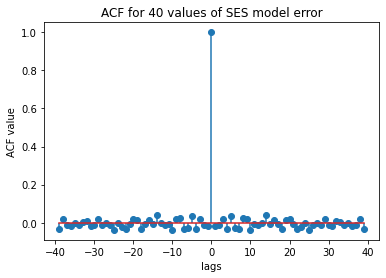

The Q value of SES model is: 69.43888557773676
The variance of SES model is: 0.00013199612908907233
The mse of SES model is: 0.00015099578690296733
The mean of SES model error is: 0.0043588596919257455
RMSE of SES error is: 0.012288034297761678


In [212]:
raw=np.array(y_test['diff'])
error_ses=raw-y_test['SES'].values
acf=[]
for i in range(40):
    acf.append(get_auto_corr(error_ses,i))
L1=np.arange(0,40,1)
L2=-L1[::-1]
x = np.concatenate((L2[0:-1], L1))
acf_reverse = acf[::-1]
ACF = np.concatenate ((acf_reverse[0:-1], acf))
plt.stem(x,ACF, use_line_collection=True, markerfmt = 'o')
plt.xlabel('lags')
plt.ylabel('ACF value')
plt.title('ACF for 40 values of SES model error')
plt.show()
acf.remove(acf[0])
acf1=np.array(acf)
Q_ses=len(error_ses)*np.sum(acf1**2)
var_ses=np.var(error_ses)
mse_ses=np.mean(error_ses**2)
mean_ses=np.mean(error_ses)
rmse_ses=(mse_ses)**0.5
print("The Q value of SES model is:",Q_ses)
print("The variance of SES model is:",var_ses)
print("The mse of SES model is:",mse_ses)
print("The mean of SES model error is:",mean_ses)
print("RMSE of SES error is:",rmse_ses)

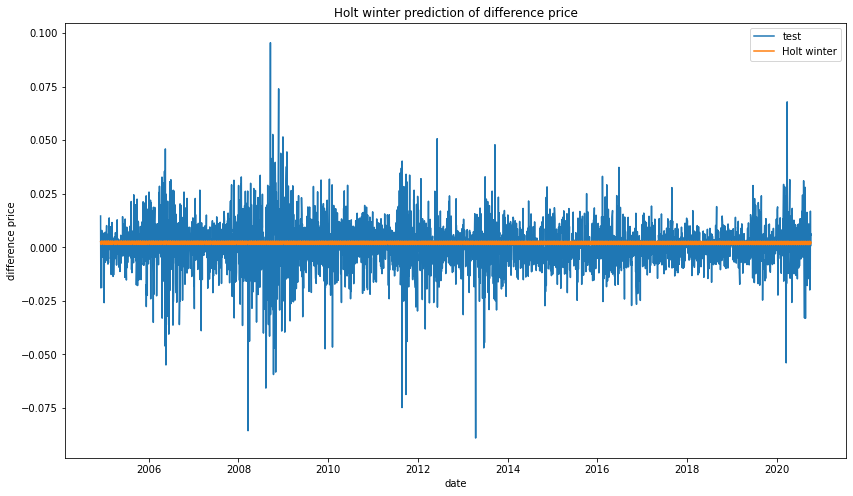

In [213]:
from statsmodels.tsa.api import ExponentialSmoothing
model_winter =ExponentialSmoothing(np.asarray(y_train['diff']), seasonal_periods=12, trend='add', seasonal='add').fit()
y_test['Holt_Winter'] = model_winter.forecast(len(y_test))
plt.figure(figsize=(14,8))
plt.plot(y_test['diff'],label="test")
plt.plot(y_test['Holt_Winter'],label="Holt winter")
plt.legend(loc="best")
plt.title('Holt winter prediction of difference price')
plt.xlabel('date')
plt.ylabel('difference price')
plt.show()

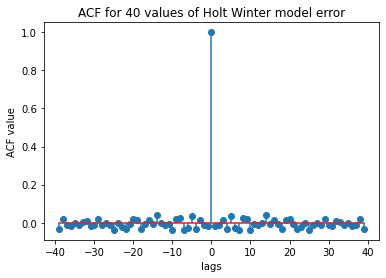

The Q value of Holt winter model is: 69.43006483020847
The variance of Holt winter model is: 0.00013202148557968601
The mse of Holt winter model is: 0.0001353617366726203
The mean of Holt winter model error is: -0.0018276353829290777
RMSE of Holt winter error is: 0.011634506292603064


In [214]:
raw=np.array(y_test['diff'])
error_winter=raw-y_test['Holt_Winter'].values
acf=[]
for i in range(40):
    acf.append(get_auto_corr(error_winter,i))
L1=np.arange(0,40,1)
L2=-L1[::-1]
x = np.concatenate((L2[0:-1], L1))
acf_reverse = acf[::-1]
ACF = np.concatenate ((acf_reverse[0:-1], acf))
plt.stem(x,ACF, use_line_collection=True, markerfmt = 'o')
plt.xlabel('lags')
plt.ylabel('ACF value')
plt.title('ACF for 40 values of Holt Winter model error')
plt.show()
acf.remove(acf[0])
acf1=np.array(acf)
Q_winter=len(error_winter)*np.sum(acf1**2)
var_winter=np.var(error_winter)
mse_winter=np.mean(error_winter**2)
mean_winter=np.mean(error_winter)
rmse_winter=(mse_winter)**0.5
print("The Q value of Holt winter model is:",Q_winter)
print("The variance of Holt winter model is:",var_winter)
print("The mse of Holt winter model is:",mse_winter)
print("The mean of Holt winter model error is:",mean_winter)
print("RMSE of Holt winter error is:",rmse_winter)

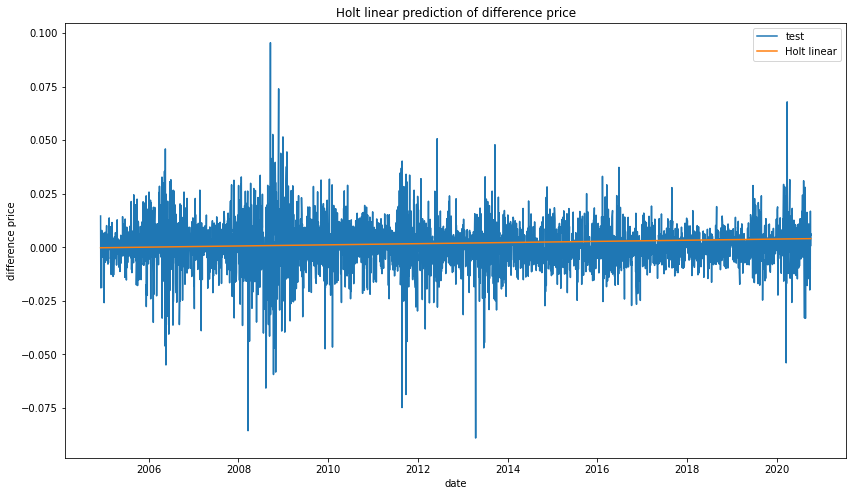

In [219]:
from statsmodels.tsa.api import Holt
#apply holt linear method to predict as from the decomposition graph, the gold price has increasing trend.
#I have tried other smoothing levels and slopes, and I found that smoothing-leel=0.3 and smoothing slope=0.1 is best
model_hl = Holt(np.asarray(y_train['diff'])).fit(smoothing_level = 0.005,smoothing_slope = 0.4)
y_test['Holt_linear'] = model_hl.forecast(len(y_test))
error_hl=raw-y_test['Holt_linear'].values
plt.figure(figsize=(14,8))
plt.plot(y_test['diff'],label="test")
plt.plot(y_test['Holt_linear'],label="Holt linear")
plt.legend(loc="best")
plt.title('Holt linear prediction of difference price')
plt.xlabel('date')
plt.ylabel('difference price')
plt.show()

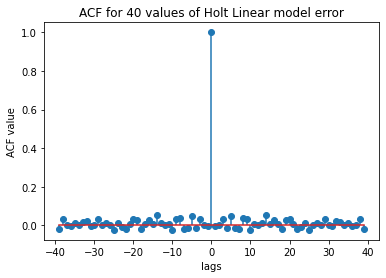

The Q value of Holt Winter model is: 73.47307322520471
The variance of Holt Winter model is: 0.00013386008728222222
The mse of Holt Winter model is: 0.0001361808272383433
The mean of Holt Winter model error is: -0.001523397504304479
RMSE of Holt Winter error is: 0.011669654118196619


In [220]:
acf=[]
for i in range(40):
    acf.append(get_auto_corr(error_hl,i))
L1=np.arange(0,40,1)
L2=-L1[::-1]
x = np.concatenate((L2[0:-1], L1))
acf_reverse = acf[::-1]
ACF = np.concatenate ((acf_reverse[0:-1], acf))
plt.stem(x,ACF, use_line_collection=True, markerfmt = 'o')
plt.xlabel('lags')
plt.ylabel('ACF value')
plt.title('ACF for 40 values of Holt Linear model error')
plt.show()
acf.remove(acf[0])
acf1=np.array(acf)
Q_hl=len(error_hl)*np.sum(acf1**2)
var_hl=np.var(error_hl)
mse_hl=np.mean(error_hl**2)
mean_hl=np.mean(error_hl)
rmse_hl=(mse_hl)**0.5
print("The Q value of Holt Winter model is:",Q_hl)
print("The variance of Holt Winter model is:",var_hl)
print("The mse of Holt Winter model is:",mse_hl)
print("The mean of Holt Winter model error is:",mean_hl)
print("RMSE of Holt Winter error is:",rmse_hl)

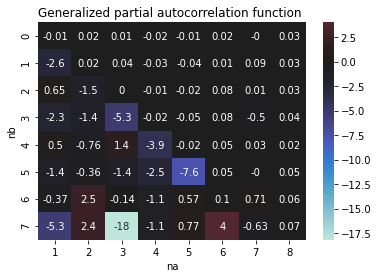

In [221]:
y=np.array(y_train['diff'])
acf=[]
for i in range(40):
    acf.append(get_auto_corr(y,i+1))
ry=[np.var(y)]
for i in range(39):
    ry.append(acf[i+1]*np.var(y))
phi=[]
phi_1=[]
i=0
gpac = np.zeros(shape=(8, 7))
for j in range(0,8):
    for k in range(2,9):
        bottom = np.zeros(shape=(k, k))
        top = np.zeros(shape=(k, k))
        for m in range(k):
            for n in range(k):
                bottom[m][n]=ry[abs(j+m - n)]
            top[m][-1]=ry[abs(j+m+1)]
        i=i+1
        top[:,:k-1] = bottom[:,:k-1]
        phi.append(round((np.linalg.det(top) / np.linalg.det(bottom)),2))
    phi_1.append(round(ry[j + 1] / ry[j],2))
gpac=np.array(phi).reshape(8,7)
Phi1=pd.DataFrame(phi_1)
Gpac=pd.DataFrame(gpac)
GPAC = pd.concat([Phi1,Gpac], axis=1)
GPAC.columns=['1','2','3','4','5','6','7','8']
import seaborn as sns
sns.heatmap(GPAC, center=0, annot=True)
plt.title("Generalized partial autocorrelation function ")
plt.xlabel("na")
plt.ylabel("nb")
plt.show()

In [374]:
import statsmodels.api as sm
model_arma=sm.tsa.ARMA(y,(2,1)).fit(trend='nc',disp=0)
print(model_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 9333
Model:                     ARMA(2, 1)   Log Likelihood               27390.626
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 25 Nov 2020   AIC                         -54773.251
Time:                        05:18:38   BIC                         -54744.686
Sample:                             0   HQIC                        -54763.549
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -0.3670      0.486     -0.755      0.450      -1.319       0.585
ar.L2.y       -0.0229      0.022     -1.065      0.287      -0.065       0.019
ma.L1.y        0.3245      0.486      0.668      0.5

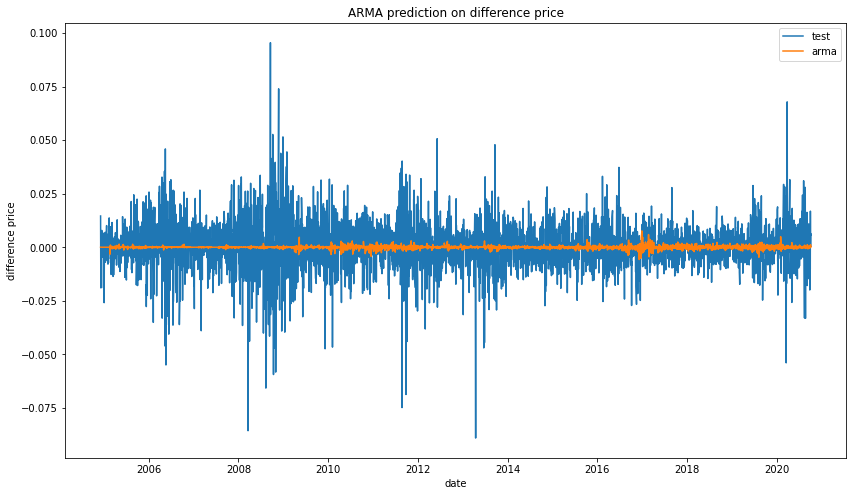

In [401]:
arma_pred = model_arma.predict(start=1,end=4000)
y_test['arma']=arma_pred
plt.figure(figsize=(14,8))
plt.plot(y_test['diff'],label="test")
plt.plot(y_test['arma'],label="arma")
plt.legend(loc="best")
plt.title('ARMA prediction on difference price')
plt.xlabel('date')
plt.ylabel('difference price')
plt.show()

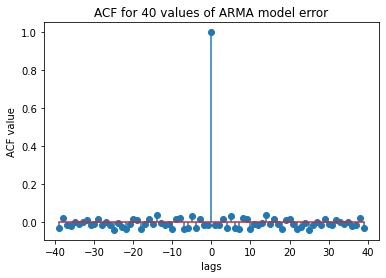

The Q value of ARMA model is: 68.49179302790853
The variance of ARMA model is: 0.0001327541080209147
The mse of ARMA model is: 0.0001329069316310536
The mean of ARMA model error is: 0.0003909266045422025
RMSE of ARMA error is: 0.011528526863006113


In [403]:
raw=np.array(y_test['diff'])
error_arma=raw-y_test['arma'].values
acf=[]
for i in range(40):
    acf.append(get_auto_corr(error_arma,i))
L1=np.arange(0,40,1)
L2=-L1[::-1]
x = np.concatenate((L2[0:-1], L1))
acf_reverse = acf[::-1]
ACF = np.concatenate ((acf_reverse[0:-1], acf))
plt.stem(x,ACF, use_line_collection=True, markerfmt = 'o')
plt.xlabel('lags')
plt.ylabel('ACF value')
plt.title('ACF for 40 values of ARMA model error')
plt.show()
acf.remove(acf[0])
acf1=np.array(acf)
Q_arma=len(error_arma)*np.sum(acf1**2)
var_arma=np.var(error_arma)
mse_arma=np.mean(error_arma**2)
mean_arma=np.mean(error_arma)
rmse_arma=(mse_arma)**0.5
print("The Q value of ARMA model is:",Q_arma)
print("The variance of ARMA model is:",var_arma)
print("The mse of ARMA model is:",mse_arma)
print("The mean of ARMA model error is:",mean_arma)
print("RMSE of ARMA error is:",rmse_arma)

In [402]:
from scipy.stats import chi2
DOF=40-3
alfa=0.001
chi_critical=chi2.ppf(1-alfa,DOF)
if Q_arma<chi_critical:
    print("the residual is white")
else:
    print("Not white")

the residual is white


In [412]:
from statsmodels.tsa.arima_model import ARIMA
model_arima=ARIMA(y,(2,1,1)).fit(trend='nc',disp=0)
print(model_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 9332
Model:                 ARIMA(2, 1, 1)   Log Likelihood               27385.915
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 25 Nov 2020   AIC                         -54763.830
Time:                        06:21:39   BIC                         -54735.265
Sample:                             1   HQIC                        -54754.128
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -0.0436      0.010     -4.205      0.000      -0.064      -0.023
ar.L2.D.y     -0.0083      0.010     -0.802      0.422      -0.029       0.012
ma.L1.D.y     -0.9992      0.001  -1356.500      0.0

In [408]:
np.roots([1,-0.05])

array([0.05])

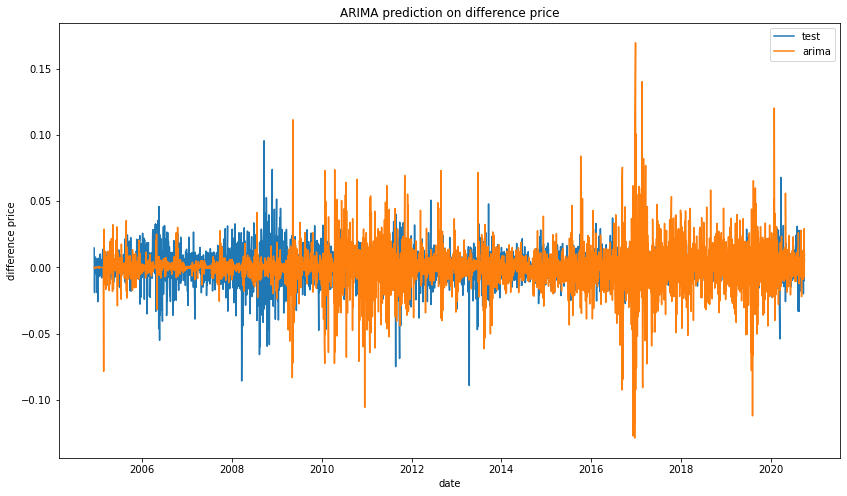

In [413]:
arima_pred = model_arima.predict(start=1,end=4000)
y_test['arima']=arima_pred
plt.figure(figsize=(14,8))
plt.plot(y_test['diff'],label="test")
plt.plot(y_test['arima'],label="arima")
plt.legend(loc="best")
plt.title('ARIMA prediction on difference price')
plt.xlabel('date')
plt.ylabel('difference price')
plt.show()

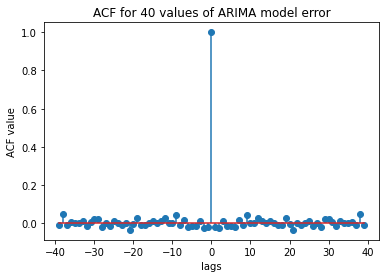

The Q value of ARIMA model is: 49.32619459227323
The variance of ARIMA model is: 0.0004394614259719637
The mse of ARIMA model is: 0.0004395646797473104
The mean of ARIMA model error is: 0.0003213312548549192
RMSE of ARIMA error is: 0.020965797856206437


In [414]:
raw=np.array(y_test['diff'])
error_arima=raw-y_test['arima'].values
acf=[]
for i in range(40):
    acf.append(get_auto_corr(error_arima,i))
L1=np.arange(0,40,1)
L2=-L1[::-1]
x = np.concatenate((L2[0:-1], L1))
acf_reverse = acf[::-1]
ACF = np.concatenate ((acf_reverse[0:-1], acf))
plt.stem(x,ACF, use_line_collection=True, markerfmt = 'o')
plt.xlabel('lags')
plt.ylabel('ACF value')
plt.title('ACF for 40 values of ARIMA model error')
plt.show()
acf.remove(acf[0])
acf1=np.array(acf)
Q_arima=len(error_arima)*np.sum(acf1**2)
var_arima=np.var(error_arima)
mse_arima=np.mean(error_arima**2)
mean_arima=np.mean(error_arima)
rmse_arima=(mse_arima)**0.5
print("The Q value of ARIMA model is:",Q_arima)
print("The variance of ARIMA model is:",var_arima)
print("The mse of ARIMA model is:",mse_arima)
print("The mean of ARIMA model error is:",mean_arima)
print("RMSE of ARIMA error is:",rmse_arima)

In [381]:
from scipy.stats import chi2
DOF=40-1
alfa=0.001
chi_critical=chi2.ppf(1-alfa,DOF)
if Q_arima<chi_critical:
    print("the residual is white")
else:
    print("Not white")

the residual is white


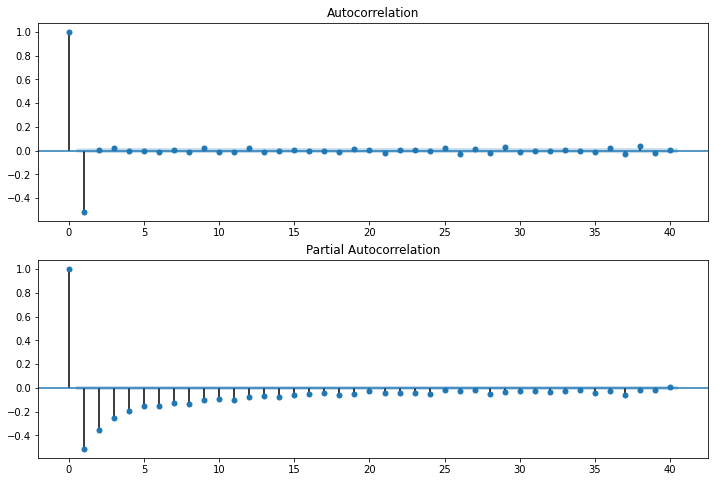

In [382]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gold['diff'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gold['diff'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [383]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima=SARIMAX(y,order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
print(model_sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 9333
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               27310.718
Date:                            Wed, 25 Nov 2020   AIC                         -54611.436
Time:                                    05:22:28   BIC                         -54575.737
Sample:                                         0   HQIC                        -54599.310
                                           - 9333                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0456      0.004    -10.548      0.000      -0.054      -0.037
ma.L1         -0.9977      0.001  -

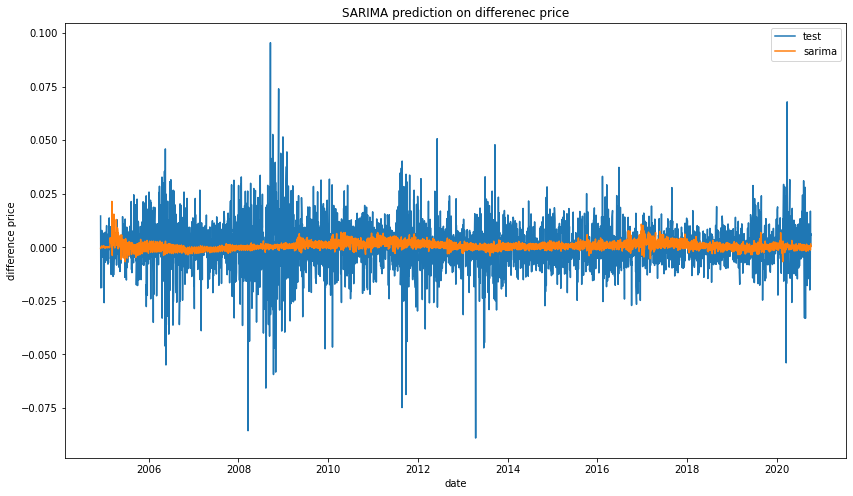

In [415]:
sarima_pred = model_sarima.predict(start=1,end=4000)
y_test['sarima']=sarima_pred
plt.figure(figsize=(14,8))
plt.plot(y_test['diff'],label="test")
plt.plot(y_test['sarima'],label="sarima")
plt.legend(loc="best")
plt.title('SARIMA prediction on differenec price')
plt.xlabel('date')
plt.ylabel('difference price')
plt.show()

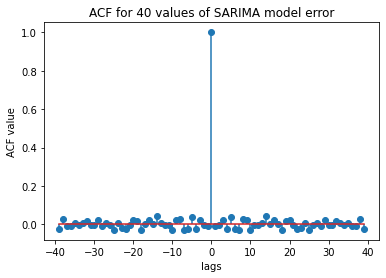

The Q value of SARIMA model is: 60.068484940431105
The variance of SARIMA model is: 0.0001353168398355941
The mse of SARIMA model is: 0.0001354324894771487
The mean of SARIMA model error is: -0.00034007299445063986
RMSE of SARIMA error is: 0.020965797856206437


In [385]:
raw=np.array(y_test['diff'])
error_sarima=raw-y_test['sarima'].values
acf=[]
for i in range(40):
    acf.append(get_auto_corr(error_sarima,i))
L1=np.arange(0,40,1)
L2=-L1[::-1]
x = np.concatenate((L2[0:-1], L1))
acf_reverse = acf[::-1]
ACF = np.concatenate ((acf_reverse[0:-1], acf))
plt.stem(x,ACF, use_line_collection=True, markerfmt = 'o')
plt.xlabel('lags')
plt.ylabel('ACF value')
plt.title('ACF for 40 values of SARIMA model error')
plt.show()
acf.remove(acf[0])
acf1=np.array(acf)
Q_sarima=len(error_sarima)*np.sum(acf1**2)
var_sarima=np.var(error_sarima)
mse_sarima=np.mean(error_sarima**2)
mean_sarima=np.mean(error_sarima)
rmse_sarima=(mse_arima)**0.5
print("The Q value of SARIMA model is:",Q_sarima)
print("The variance of SARIMA model is:",var_sarima)
print("The mse of SARIMA model is:",mse_sarima)
print("The mean of SARIMA model error is:",mean_sarima)
print("RMSE of SARIMA error is:",rmse_sarima)

In [386]:
from scipy.stats import chi2
DOF=40-1
alfa=0.001
chi_critical=chi2.ppf(1-alfa,DOF)
if Q_sarima<chi_critical:
    print("the residual is white")
else:
    print("Not white")

the residual is white


In [387]:
y_test.head()

,diff,SES,Holt_Winter,Holt_linear,arma,arima,sarima
Date,,,,,,,
2004-12-06,0.014588,-0.003997,0.002605,-0.000243,2.397035e-05,0.000000e+00,-5.686665e-04
2004-12-07,-0.004398,-0.003997,0.002350,-0.000242,2.945529e-05,1.674925e-07,-5.689901e-04
2004-12-08,-0.017788,-0.003997,0.001812,-0.000241,3.476603e-06,-3.964995e-04,-1.967219e-13
2004-12-09,-0.019024,-0.003997,0.002455,-0.000240,-1.128274e-06,-2.991854e-04,8.964326e-15
2004-12-10,-0.007920,-0.003997,0.001297,-0.000239,3.661629e-07,-2.379451e-04,-4.084914e-16


In [399]:
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
data={'method':['SES','Holt Linear','Holt Winter','ARMA','ARIMA','SARIMA'],
      'MSE':[mse_ses,mse_hl,mse_winter,mse_arma,mse_arima,mse_sarima],
      'mean':[mean_ses,mean_hl,mean_winter,mean_arma,mean_arima,mean_sarima],
      'variance':[var_ses,var_hl,var_winter,var_arma,var_arima,var_sarima],
      'Q value':[Q_ses,Q_hl,Q_winter,Q_arma,Q_arima,Q_sarima],
      'RMSE':[rmse_ses,rmse_hl,rmse_winter,rmse_arma,rmse_arima,rmse_sarima]}
table=pd.DataFrame(data)
print(table)

        method       MSE      mean  variance    Q value      RMSE
0          SES  0.000151  0.004359  0.000132  69.438886  0.012288
1  Holt Linear  0.000136 -0.001523  0.000134  73.473073  0.011670
2  Holt Winter  0.000135 -0.001828  0.000132  69.430065  0.011635
3         ARMA  0.000133  0.000391  0.000133  68.491793  0.011529
4        ARIMA  0.000440  0.000321  0.000439  49.326195  0.020966
5       SARIMA  0.000135 -0.000340  0.000135  60.068485  0.020966
